# Modules

In [ ]:
import gurobipy
from gurobipy import *

from random import randint
import pandas as pd
import numpy as np
import json

# for creating a responsive plot
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Input Data

In [ ]:
# Opening JSON file
instance_name = "./data/large_instance"
f = open(instance_name+".json")
# returns JSON object as a dictionary
data = json.load(f)

In [ ]:
## Problem's parameters :

S = len(data["staff"]) # Number of individuals
H = data["horizon"]+1 # Horizon
J = len(data["jobs"]) # Number of projects
Q = len(data["qualifications"]) # Number of qualifications

# Transform Data

In [ ]:
## def functions from json
def vacations(collaborator, day):
    if day in collaborator["vacations"]:
        return 1
    else:
        return 0
def has_qualification(collaborator,qualification):
    # numbered collaborator
    if data["qualifications"][qualification] in data["staff"][collaborator]["qualifications"]:
        return 1
    else:
        return 0

def project_necessary_qualifications(project,qualification):
    if data["qualifications"][qualification] in data["jobs"][project]["working_days_per_qualification"].keys():
        return data["jobs"][project]["working_days_per_qualification"][data["qualifications"][qualification]]
    else:
        return 0
def gain(project):
    return project["gain"]

def date_rendu(project):
    return project["due_date"]

def penalite(project):
    return project["daily_penalty"]

# Model

In [ ]:
# Create a new model
m = Model()

## Decision Variables

In [ ]:
## variables
M = 1000
## Create variable rea (realisation of project)
X = {}
Y = {}
L={}
E= {}
Debut = {}
b = {}
shift_change={}

for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                X[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="X["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")
for j in range(J):
    Y[j]=m.addVar(vtype=GRB.BINARY,name="Y["+str(j)+"]")
    L[j]=m.addVar(vtype=GRB.INTEGER,name="L["+str(j)+"]")
    E[j]=m.addVar(vtype=GRB.INTEGER,name="E["+str(j)+"]")
    Debut[j]=m.addVar(vtype=GRB.INTEGER,name="Debut["+str(j)+"]")
for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                b[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="binary decision 2["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")
                shift_change[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="Shift Change ["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")

## Constraints

In [ ]:
for i in range(S):
    for t in range(H):
        m.addConstr(quicksum(X[i,j,k,t] for j in range(J) for k in range(Q)) <=1)
for i in range(S):
    for t in range(H):
        if vacations(data["staff"][i],t)>0:
            m.addConstr(quicksum(X[i,j,k,t] for j in range(J) for k in range(Q))==0)
for i in range(S):
    for j in range(J):
        for k in range(Q):
            if (has_qualification(i,k)==0) or (project_necessary_qualifications(j,k)==0):
                for t in range(H):
                    m.addConstr(X[i,j,k,t]==0)
for j in range(J):
    for k in range(Q):
        if project_necessary_qualifications(j,k)>0:
            m.addConstr(Y[j]*project_necessary_qualifications(j,k) <= quicksum(X[i,j,k,t] for i in range(S) for t in range(H)))

for j in range(J):
    for k in range(Q):
        if project_necessary_qualifications(j,k)>0:
            m.addConstr(quicksum(X[i,j,k,t] for i in range(S) for t in range(H)) <= project_necessary_qualifications(j,k))
        
for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                m.addConstr(X[i,j,k,t]*t <= E[j])
                m.addConstr(t*X[i,j,k,t] >= Debut[j])
        m.addConstr(Debut[j] <= E[j])
                
for j in range(J):
    m.addConstr(E[j]-date_rendu(data["jobs"][j])<=L[j])


## Objective function

In [ ]:
## Set objective function

## Fonction obj 1: Maximize profits
profits = LinExpr()
profits = quicksum( Y[j]*gain(data["jobs"][j]) - L[j]*penalite(data["jobs"][j]) for j in range(J))

m.setObjective(profits,GRB.MAXIMIZE)

#Update Modèle
m.update()

In [ ]:
m.params.outputflag = 0

solution_dict = {}
for nbr_shifts in range(H,int(J/S),-1):
    for nbr_jours_max_projet in range(H,-1,-1):
        cons = []
        for i in range(S):
            for j in range(J):
            #for k in range(Q):
                for t in range(H-1):                                
                    cons.append(m.addConstr(shift_change[i,j,k,t]>=0))
                    cons.append(m.addConstr(shift_change[i,j,k,t]>=quicksum(X[i,j,k,t+1]-X[i,j,k,t] for k in range(Q))))
                    cons.append(m.addConstr(shift_change[i,j,k,t]<=M*(1-b[i,j,k,t])))
                        #cons.append(m.addConstr(shift_change[i,j,k,t]<=X[i,j,k,t+1]-X[i,j,k,t]+M*b[i,j,k,t]))
                        #m.optimize()
            cons.append(m.addConstr(quicksum(shift_change[i,j,k,t] for j in range(J) for k in range(Q) for t in range(H)) <= nbr_shifts))
        cons.append(m.addConstr(E[j]-Debut[j] <= nbr_jours_max_projet))
        m.update()
        print("starting")
        m.optimize()
        solution_dict[nbr_shifts,nbr_jours_max_projet] = json.loads(m.getJSONSolution())
        print("nbr shifts",nbr_shifts,"nbr_jours_max_projet",nbr_jours_max_projet,solution_dict[nbr_shifts,nbr_jours_max_projet]["SolutionInfo"]["PoolObjVal"][0])

        for c in cons:
            m.remove(c)

In [ ]:
    for nbr_jours_max_projet in range(28,-1,-1):
        cons = []
        for i in range(S):
            for j in range(J):
            #for k in range(Q):
                for t in range(H-1):                                
                    cons.append(m.addConstr(shift_change[i,j,k,t]>=0))
                    cons.append(m.addConstr(shift_change[i,j,k,t]>=quicksum(X[i,j,k,t+1]-X[i,j,k,t] for k in range(Q))))
                    cons.append(m.addConstr(shift_change[i,j,k,t]<=M*(1-b[i,j,k,t])))
                        #cons.append(m.addConstr(shift_change[i,j,k,t]<=X[i,j,k,t+1]-X[i,j,k,t]+M*b[i,j,k,t]))
                        #m.optimize()
            cons.append(m.addConstr(quicksum(shift_change[i,j,k,t] for j in range(J) for k in range(Q) for t in range(H)) <= nbr_shifts))
        cons.append(m.addConstr(E[j]-Debut[j] <= nbr_jours_max_projet))
        m.update()
        print("starting")
        m.optimize()
        solution_dict[nbr_shifts,nbr_jours_max_projet] = json.loads(m.getJSONSolution())
        print("nbr shifts",nbr_shifts,"nbr_jours_max_projet",nbr_jours_max_projet,solution_dict[nbr_shifts,nbr_jours_max_projet]["SolutionInfo"]["PoolObjVal"][0])

        for c in cons:
            m.remove(c)

In [ ]:
solution_dict = b

In [ ]:

import pickle 

with open('large_solution.txt', 'rb') as handle:
  b = pickle.loads(handle.read())

## Non dominated Solutions

In [ ]:
solution_dict[]

In [ ]:
solution_reduite = {}
for key in solution_dict:
    solution_reduite[key[0],key[1],solution_dict[key]["SolutionInfo"]["ObjVal"]] = solution_dict[key]["Vars"]

In [ ]:
# select only non dominated solutions
def get_non_dominated_solutions(solution_reduite):
    # get the objective values
    obj_val = list(solution_reduite.keys())
    # get the number of solutions
    nb_sol = len(solution_reduite)
    # get the number of objectives
    nb_obj = 3
    # get the index of the solutions that are non dominated
    non_dominated_solutions = {}
    for i in range(nb_sol):
        dominated = False
        for j in range(nb_sol):
            if i != j:
                if all(obj_val[i][k] >= obj_val[j][k] for k in range(nb_obj-1)) and obj_val[i][nb_obj-1] <= obj_val[j][nb_obj-1]:
                    dominated = True
        if not dominated:
            non_dominated_solutions[obj_val[i]] = solution_reduite[obj_val[i]]
    return non_dominated_solutions

non_dominated_sol = get_non_dominated_solutions(solution_reduite)

# Solutions visualisation

In [ ]:
import plotly.graph_objects as go


Z = np.zeros((37,37))
for i in range(37):
    for j in range(37):
        try:
            Z[j,i]=solution_dict[i,j]["SolutionInfo"]["PoolObjVal"][0]
            print(i,j,solution_dict[i,j]["SolutionInfo"]["PoolObjVal"][0])
        except:
            Z[i,j]=0
            continue
            


fig = go.Figure(go.Surface(
    
    contours = {
        "z": {"show": True, "start": 0, "end":np.max(Z) , "size": 1, "color":"black"}
    },
    x = np.arange(37),
    y = np.arange(37),
    z = Z,
    colorscale = 'RdBu',
    showscale = True
))

for key in non_dominated_sol.keys():
    print(key)
    fig.add_scatter3d(x=[key[0]], y=[key[1]], z=[key[2]], mode='markers', marker=dict(size=10, color='red'), showlegend=False)




fig.update_layout(
        scene = {
            "xaxis": {"nticks": 0},
            "zaxis": {"nticks": 0},
            'camera_eye': {"x": 1, "y": 1, "z": 1},
            "aspectratio": {"x": 0, "y": 0, "z": 1}
        } ,
        margin=go.layout.Margin(
        l=0, 
        r=0, 
        b=0, 
        t=0, 
    )
        ) 

fig.update_layout(scene = dict(
                    xaxis_title='Shifts',
                    yaxis_title='Jours',
                    zaxis_title='Gain'),
)

        
fig.show()

## Planning of a Solution

In [ ]:
list_solution = []
for key, value in non_dominated_sol.items():
    solution = {}
    for i in range(len(value)):
        if value[i]['VarName'][:2]=="X[":
            print(value[i])
            index = value[i]['VarName']
            try:
                solution[int(index[2]),int(index[4]),int(index[6]),int(index[8])] = int(value[i]['X'])
            except Exception as e:
                print( index)
                solution[int(index[2]),int(index[4]),int(index[6]),int(index[8])] = value[i]['X']

    list_solution.append(solution)

In [ ]:
def get_planning(solution):
    # Dataframe with affectations
    planning = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(H)],index = [i for i in range(S)])
    for i in range(S): # I
        for j in range(J): # P
            for k in range(Q): # Q
                for t in range(H): # J
                    if (i,j,k,t) in solution:
                        planning.iloc[i,t] = k
    ## colors cells with regard to project
    color_pro = {}
    for i in range(J):
        color_pro[i] = '#%06X' % randint(0, 0xFFFFFF)

    df_color = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(H)],index = [i for i in range(S)])
    for i in range(S): 
        for j in range(J): 
            for k in range(Q):
                for t in range(H): 
                    if (i,j,k,t) in solution: 
                            df_color.iloc[i,t] = color_pro[j]
    df_color = df_color.applymap(lambda x: 'background-color: {}'.format(x))
    def highlight_1(x):
        return pd.DataFrame(df_color.values, columns=x.columns)
    planning = planning.astype('Int64')
    planning = planning.style.apply(highlight_1,axis=None)
    # Mapping colors to projects
    proj_col = pd.DataFrame()
    i=0
    jobs = [ job["name"] for job in data['jobs']]
    for project in jobs:
        proj_col = pd.concat([proj_col,pd.DataFrame({'project':project,'color': 'background-color: ' + color_pro[i]},index=[i])], axis=0)
        i+=1
    def highlight_2(x):
        return x
    proj_col = proj_col.style.apply(highlight_2,axis=None, subset=['color'])
    return planning, proj_col

In [ ]:
for sol in list_solution:
    planning, proj_col = get_planning(sol)
    display(planning)
    display(proj_col)

# systèmes de choix/préférence

In [ ]:
dico = {}
for count,value in enumerate(solution_reduite):
    dico[count]=value

In [ ]:
def bordas_ranking(dico):
    df = pd.DataFrame.from_dict(dico, orient='index', columns=['gain','shift_change','diff'])
    df['default_rank'] = df['gain'].rank(method='min', ascending=False)
    df['shift_change_rank'] = df['shift_change'].rank(method='min', ascending=False)
    df['diff_rank'] = df['diff'].rank(method='min', ascending=False)
    df['borda'] = df['default_rank'] + df['shift_change_rank'] + df['diff_rank']
    df = df.sort_values(by = 'borda', ascending = True)
    return df


def somme_ponderee(dico,poids1=1,poids2=0.5,poids3=0.5):
    for i in dico.keys():
        dico[i] = dico[i],np.sum(dico[i]*np.array([poids1,poids2,poids3]))
    return {k: v[0] for k, v in sorted(dico.items(), key=lambda item: item[0])}

def fonction_seuil(dico,seuil,fonction_a_appeler):
    max_gain = max(np.array(list(dico.values())).T[0])
    list_to_keep = {}
    for key, values in enumerate(dico.values()):
        if values[0] >=max_gain*seuil:
            list_to_keep[key] = dico[key]
    print(list_to_keep)
    return fonction_a_appeler(list_to_keep)

In [ ]:
fonction_seuil(dico,0.99,bordas_ranking)

## Apprentissage des préférences à partir d'info à priori

In [ ]:
import skcriteria as skc
from skcriteria.madm import similarity  # here lives TOPSIS
from skcriteria.pipeline import mkpipe  # this function is for create pipelines
from skcriteria.preprocessing import invert_objectives, scalers
from skcriteria.madm import simple
from skcriteria.madm import electre

from skcriteria.cmp import RanksComparator, mkrank_cmp

from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.invert_objectives import (
    InvertMinimize,
    NegateMinimize,
)
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.madm.simple import  WeightedSumModel
from skcriteria.madm.similarity import TOPSIS


/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_189706/3813578477.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a 

Alternatives,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9
Rank,6,2,4,9,1,3,5,7,10,8


Alternatives,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9
Rank,6,2,1,7,5,3,4,8,9,10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


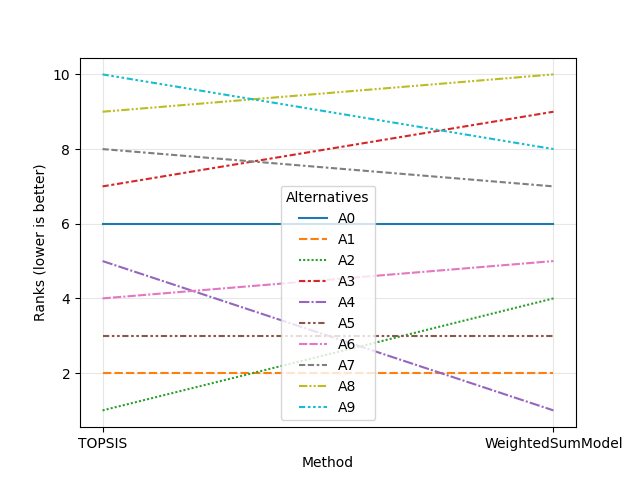

In [238]:
dataframe_solutions = pd.DataFrame(columns=["NBR_SHIFTS","MAX_DAYS_PER_PROJEJT","GAIN"])
for i,j,k in non_dominated_sol.keys():
    dataframe_solutions = dataframe_solutions.append(pd.DataFrame([[i,j,k]],
                                                                 columns = ["NBR_SHIFTS","MAX_DAYS_PER_PROJEJT","GAIN"]))
dataframe_solutions = dataframe_solutions.reset_index(drop=True)

matrix = dataframe_solutions.values



dm = skc.mkdm(
matrix,
[min, min, max],
weights=[0.02, 0.02, 1-0.02*2],
criteria=["nbr shifts", "max days", "gain"],
)



ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedSumModel(),
)


tp_pipe = mkpipe(
    NegateMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS(),
)

wsum_result = ws_pipe.evaluate(dm)
tp_result = tp_pipe.evaluate(dm)

display(wsum_result, tp_result)

RanksComparator([("ts", tp_result), ("ws", wsum_result)])
rcmp = mkrank_cmp(tp_result, wsum_result)



rcmp.to_dataframe()


fig = plt.figure()
ax = plt.subplot(111)
box = ax.get_position()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
rcmp.plot.flow()
plt.show()

In [ ]:
rcmp.plot.reg(r2=True, r2_fmt=".3f");
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.bar(ax=axs[0])
rcmp.plot.barh(ax=axs[1])

fig.tight_layout();

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.box(ax=axs[0])
rcmp.plot.box(ax=axs[1], orient="h")

fig.tight_layout();